# The notebook performs exploratory data analysis (EDA) on the SGIJ MySQL Dataset

Make a EDA Study for all players activate during a year selected

In [263]:
import math
from datetime import date
from datetime import datetime
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib
import matplotlib.pyplot as plt
import mysql.connector
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.stats import linregress
from scipy import stats
from collections import Counter, OrderedDict
%matplotlib inline

register_matplotlib_converters()

Connect to MySQL databasef from credentials

NoteNook Year EDA Study

In [2]:
YEAR = 2015

MySQL Database connection string

In [3]:
config = {
  'user': 'root',
  'password': 'thingtrack',
  'host': '127.0.0.1',
  'database': 'gaming',
  'raise_on_warnings': True,
  'charset': 'utf8'
}

try:
  cnx = mysql.connector.connect(**config)
except mysql.connector.Error as err:
  if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
    print("Something is wrong with your user name or password")
  elif err.errno == errorcode.ER_BAD_DB_ERROR:
    print("Database does not exist")
  else:
    print(err)

## Sex player distribution

Get raw Dataset

In [4]:
cursor = cnx.cursor()

query = ('SELECT pl.sex, COUNT(pl.sex) as total'
        ' FROM player pl'
        ' WHERE YEAR(pl.activation_date) = %s'
        ' GROUP BY pl.sex' 
        ' ORDER BY pl.sex') %YEAR

cursor.execute(query)

# return a list of tuples
result_sex = list(cursor.fetchall())

Plot sex distribution Dataset

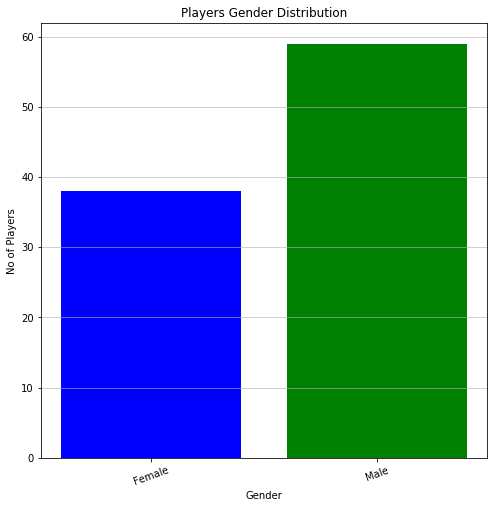

Female Dataset Size: 38
Male Dataset Size: 59
------------------------
Dataset Size: 97


In [19]:
data = np.array(result_sex) # numpy convert to string all values
labels = data[:, 0]
values = data[:, 1].astype(int)
    
plt.figure(figsize=(8, 8))  
plt.bar(labels, values, color=('blue', 'green'))
plt.title('Players Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('No of Players')
plt.xticks(np.arange(labels.size), ('Female', 'Male'), rotation=20)
plt.grid(axis='y', alpha=0.75)
plt.show()

print('Female Dataset Size: ' + str(values[0]))
print('Male Dataset Size: ' + str(values[1]))
print('------------------------')
print('Dataset Size: ' + str(sum(values)))

## Betting Frequency

Get raw dataset for betting frequency, total number of activity days (days on witch a player placed at least one live-action bet))

In [77]:
cursor = cnx.cursor()

query = ("SELECT COUNT(*) AS total"
         " FROM player pl, account ac"
         " WHERE pl.operator_id = ac.operator_id"
         "   AND pl.player_id = ac.player_id"
         "   AND YEAR(pl.activation_date) = %s"
         " GROUP BY ac.operator_id, ac.player_id") %YEAR

cursor.execute(query)

# return a list of tuples
result_betting_frequency = list(cursor.fetchall())

Plot betting frequency distribution per player

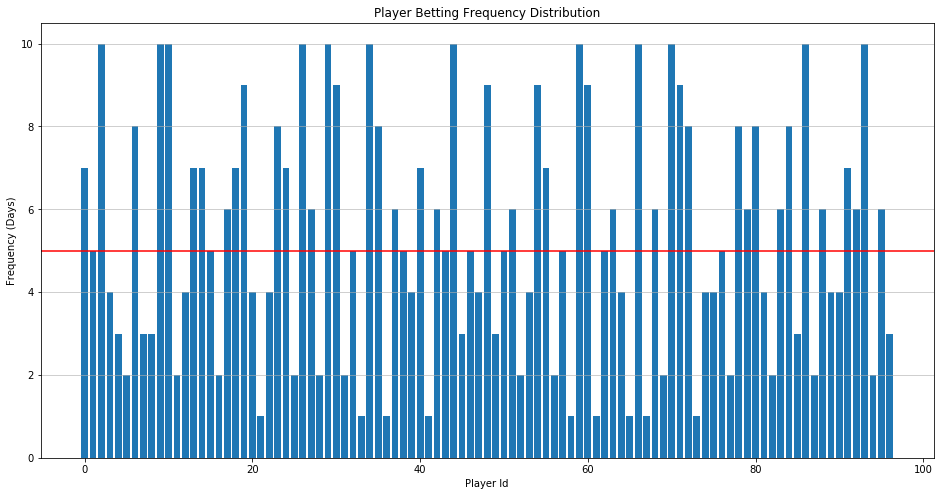

Mean bettings days: 5.0


In [109]:
data = np.array(result_betting_frequency) # numpy convert to string all values
data = data.astype(int)

betting_frequency_values = data[:, 0]

mean = round(betting_frequency_values.mean())

#print(betting_frequency_values.size)

plt.figure(figsize=(16, 8))  
plt.bar(np.arange(betting_frequency_values.size), betting_frequency_values)
plt.title('Player Betting Frequency Distribution')
plt.xlabel('Player Id')
plt.ylabel('Frequency (Days)')
plt.axhline(y=mean, color='r', linestyle='-')
plt.grid(axis='y', alpha=0.75)
plt.show()

print('Mean bettings days: ' + str(mean))

## Betting Intensity

Get raw dataset for betting intensity, total number of live-action bets divided by frequency.

In [8]:
cursor = cnx.cursor()

query = ("SELECT SUM(bettings) / COUNT(*) as total"
         " FROM player pl, account ac"
         " WHERE pl.operator_id = ac.operator_id"
         "   AND pl.player_id = ac.player_id"
         "   AND YEAR(pl.activation_date) = %s"                  
         " GROUP BY pl.operator_id, pl.player_id;") %YEAR

cursor.execute(query)

# return a list of tuples
result_betting_intensity = list(cursor.fetchall())

Plot betting intensity distribution per player

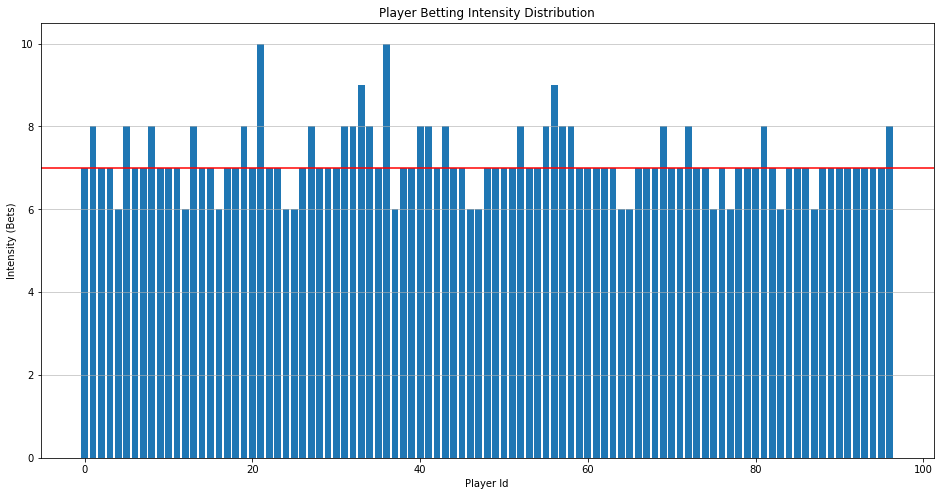

Mean Betting Intensity : 7.0


In [111]:
data = np.array(result_betting_intensity) # numpy convert to string all values
data = data.astype(int)

betting_intensity_values = data[:, 0]

mean = round(betting_intensity_values.mean())

#print(betting_intensity_values.size)

plt.figure(figsize=(16, 8))
plt.bar(np.arange(betting_intensity_values.size), betting_intensity_values)
plt.title('Player Betting Intensity Distribution')
plt.xlabel('Player Id')
plt.ylabel('Intensity (Bets)')
plt.axhline(y=mean, color='r', linestyle='-')
plt.grid(axis='y', alpha=0.75)
plt.show()

print('Mean Betting Intensity : ' + str(mean))

## Betting Intensity Histogram

Get raw dataset for betting Intensity Histogram

In [11]:
cursor = cnx.cursor()

query = ("SELECT SUM(bettings) as total"
         " FROM player pl, account ac"
         " WHERE pl.operator_id = ac.operator_id"
         "   AND pl.player_id = ac.player_id"
         "   AND YEAR(pl.activation_date) = %s"                  
         " GROUP BY pl.operator_id, pl.player_id;") %YEAR

cursor.execute(query)

# return a list of tuples
result_betting_histogram = list(cursor.fetchall())

Plot betting betting intesity histogram

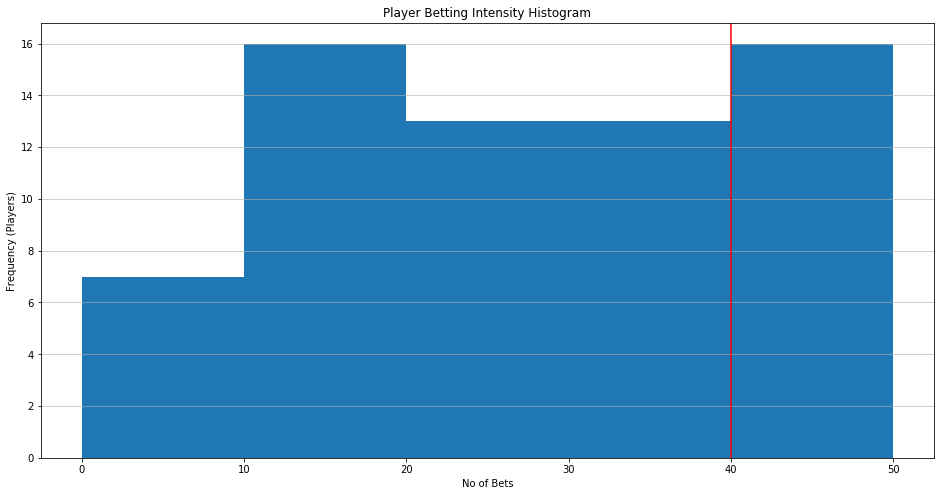

Mean Betting Intensity : 40.0


In [90]:
data = np.array(result_betting_histogram) # numpy convert to string all values
data = data.astype(int)

#labels = data[:, 0]
values = data[:, 0]

mean = round(values.mean())

plt.figure(figsize=(16, 8))
cuenta, cajas, ignorar = plt.hist(values, bins=np.arange(0, 60, 10))
plt.title('Player Betting Intensity Histogram')
plt.xlabel('No of Bets')
plt.ylabel('Frequency (Players)')
plt.axvline(x=mean, color='r', linestyle='-')
plt.grid(axis='y', alpha=0.75)
plt.show()

print('Mean Betting Intensity : ' + str(mean))

## Betting Variability

Get raw Dataset for Betting Variability. Standard Deviation of wagers

In [100]:
cursor = cnx.cursor()

query = ("SELECT ac.operator_id as operator_id, ac.player_id as player_id, SUM(ac.bettings) as total"
         " FROM player pl, gaming.account ac"
         " WHERE pl.operator_id = ac.operator_id"
         "   AND pl.player_id = ac.player_id"
         "  AND YEAR(pl.activation_date) = %d"
         " GROUP BY ac.operator_id, ac.player_id, DATE(ac.checkin_time)"
         " ORDER BY ac.operator_id, ac.player_id") %YEAR

cursor.execute(query)

# return a list of tuples
result_betting_variability = list(cursor.fetchall())

Plot betting betting variability distribution per player

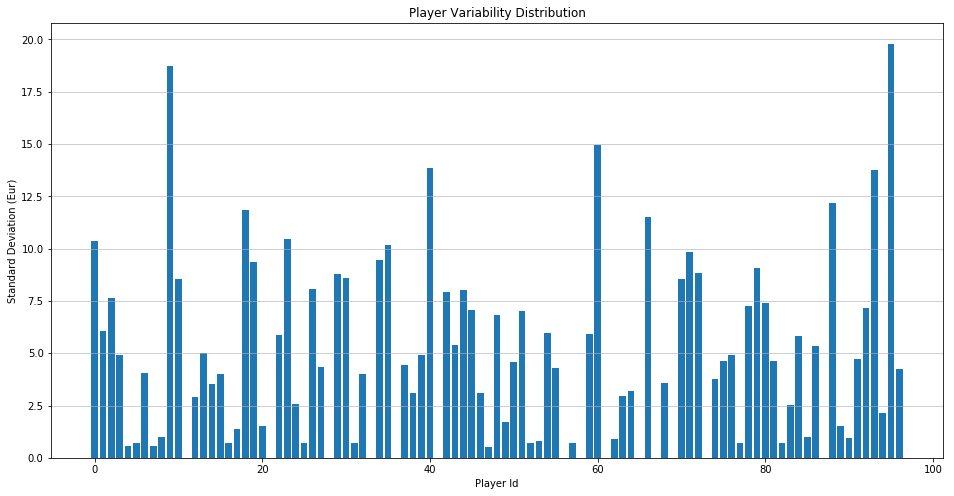

In [165]:
data = np.array(result_betting_variability) # numpy convert to string all values()
data = data.astype(int)

df = pd.DataFrame({'operator_id': data[:,0], 
                   'player_id': data[:,1],
                   'bettings': data[:,2]})

# calculate the standard deviation grouped by operator and player and replace NaN to zero
df = df.groupby(['operator_id', 'player_id']).std().fillna(0)
#print(df.groupby(['operator_id', 'player_id']).head())

# convert pandas dataframe to numpy vector
betting_variability_values = df.values.flatten()

# plot player variance
plt.figure(figsize=(16, 8))
plt.bar(np.arange(betting_variability_values.size), betting_variability_values)
plt.title('Player Variability Distribution')
plt.xlabel('Player Id')
plt.ylabel('Standard Deviation (Eur)')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Betting Trajectory

Get raw Dataset for Betting Trajectory. The tendency to increse or decrease the amount of wagers money

In [166]:
cursor = cnx.cursor()

query = ("SELECT pl.operator_id, pl.player_id, bettings as total"
         " FROM player pl, account ac"
         " WHERE pl.operator_id = ac.operator_id"
         "   AND pl.player_id = ac.player_id"
         "   AND YEAR(pl.activation_date) = %s") %YEAR

cursor.execute(query)

# return a list of tuples
result_betting_trayectory = list(cursor.fetchall())

Plot betting trajectory distribution per player

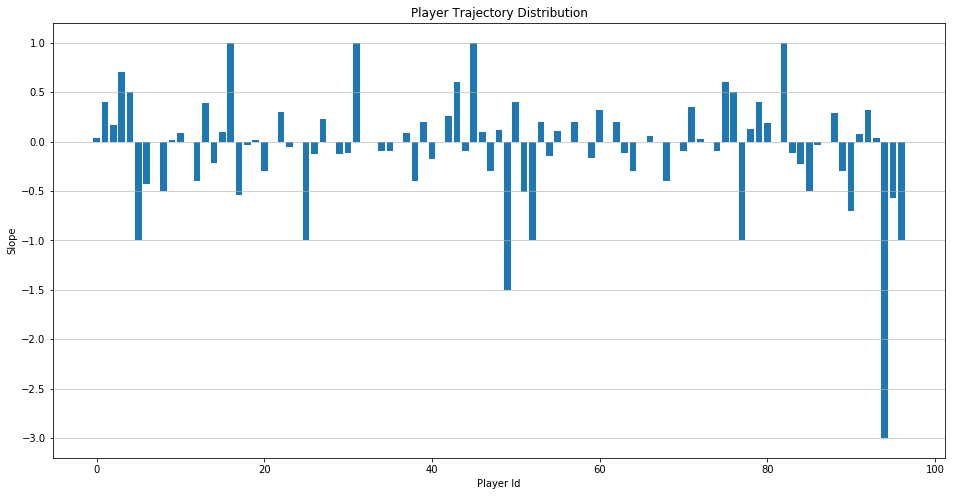

In [167]:
data = np.array(result_betting_trayectory) # numpy convert to string all values()
data = data.astype(int)

df = pd.DataFrame({'operator_id': data[:,0], 
                   'player_id': data[:,1],
                   'bettings': data[:,2]})

# get bettings grouped by operator and player
result = df.groupby(['operator_id', 'player_id'])['bettings'].apply(list)

# calculate the slope for each bettings collection group by operator and player
betting_trajectory_values = [linregress(np.arange(len(x)), x).slope for x in result] 

# replace NaN to zero
betting_trajectory_values = np.nan_to_num(betting_trajectory_values)

# plot player trayectory
plt.figure(figsize=(16, 8))
plt.bar(np.arange(0, len(betting_trajectory_values)), betting_trajectory_values)
plt.title('Player Trajectory Distribution')
plt.xlabel('Player Id')
plt.ylabel('Slope')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Clustering Betting from predictors (independent characteristics)

Before clustering to assure comparatibility, we standardized all variables using z transformation

In [358]:
predictors = pd.DataFrame({'Frequency (days)': betting_frequency_values, 
                           'Intensity (bets)': betting_intensity_values,
                           'Variability (Euro)': betting_variability_values,
                           'Trajectory (Slope)': betting_trajectory_values})

X = stats.zscore(predictors)

# create k-means for the cluster
model = KMeans(n_clusters=4)
model.fit(X)

def ClusterIndicesNumpy(clustNum, labels_array):
    return np.where(labels_array == clustNum)[0]

labels = Counter(model.labels_)
centroids = model.cluster_centers_

columns = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']
index =['Frequency (days)', 'Intensity (bets)', 'Variability (Euro)', 'Trajectory (Slope)', 'N']

centroides = centroids.T
centroides = np.vstack([centroides, [len(ClusterIndicesNumpy(0, model.labels_)),
                                     len(ClusterIndicesNumpy(1, model.labels_)),
                                     len(ClusterIndicesNumpy(2, model.labels_)),
                                     len(ClusterIndicesNumpy(3, model.labels_))]])

print(pd.DataFrame(centroides, index = index, columns = columns))



#print(ClusterIndicesNumpy(3, model.labels_))

# to call the predict function with a single observation
#model.predict([ 5.1, 3.5, 1.4, 0.2 ])


                    Cluster 1  Cluster 2  Cluster 3  Cluster 4
Frequency (days)    -0.498669   1.075934  -0.984833  -0.666369
Intensity (bets)    -0.636252  -0.065882  -0.051949   1.544870
Variability (Euro)   0.250808   0.088117  -2.340843   0.374281
Trajectory (Slope)  -0.558115   1.057824  -0.755388  -0.607677
N                   37.000000  35.000000   8.000000  17.000000


## Clustering Betting Model

In [283]:
# create dataset from database
cursor = cnx.cursor()

query = ("SELECT pl.birthdate, SUM(ac.profit) AS profit"
         " FROM player pl, account ac"
         " WHERE pl.operator_id = ac.operator_id"
         " AND pl.player_id = ac.player_id"
         " GROUP BY ac.operator_id, ac. player_id")

cursor.execute(query)

# return a list of tuples
result_km_players = list(cursor.fetchall())

Transform date characteristics and create tuples

In [171]:
# separate tuples
dates, profits = zip(*result_km_players)

# convert string to date
#dates = [pd.to_datetime(d) for d in dates]

helper = np.vectorize(lambda x: datetime.combine(x, datetime.min.time()).timestamp())

X = []
for row in result_km_players:
    X.append([helper(row[0]), row[1]])

Plot Age vs Profit Scatter Plot

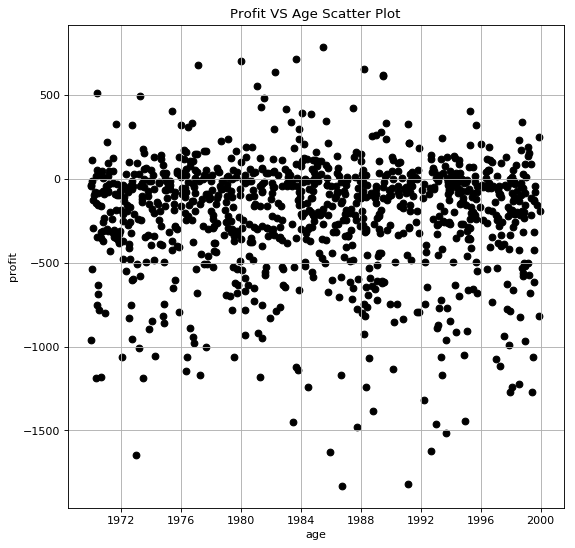

In [172]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(dates, profits, color='k')
plt.title("Profit VS Age Scatter Plot")
plt.xlabel("age")
plt.ylabel("profit")
plt.grid()
plt.show()

Design de k-means with 2 clusters model for dataset

In [185]:
model = KMeans(n_clusters=2).fit(X)

Print k-means centroides

In [11]:
centroides = []
for row in model.cluster_centers_:
    centroides.append((datetime.fromtimestamp(int(round(row[0]))), row[1]))

print(centroides)    

centroides_dates, centroides_profits = zip(*centroides)

[(datetime.datetime(1977, 7, 12, 17, 11, 24), -203.2495049504955), (datetime.datetime(1992, 7, 7, 5, 6, 4), -242.3494949494953)]


Plot the scatter plot and the centroides for tha dataset

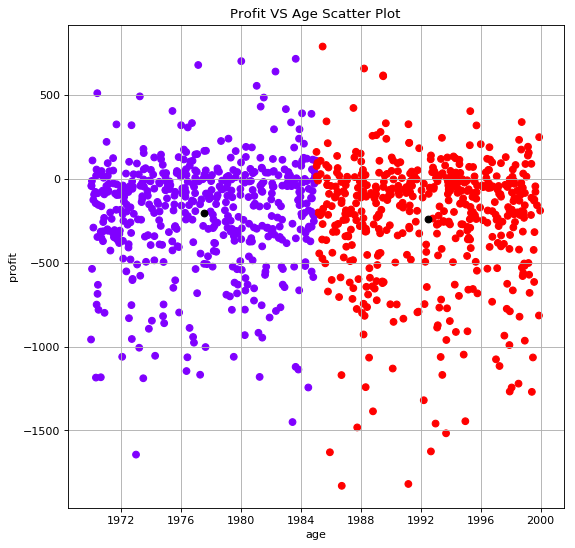

In [12]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(dates, profits, c=model.labels_, cmap='rainbow')
plt.scatter(centroides_dates ,centroides_profits, color='black')
plt.title("Profit VS Age Scatter Plot")
plt.xlabel("age")
plt.ylabel("profit")
plt.grid()
plt.show()